In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
df=pd.read_csv('news_articles.csv')['Content']

# Data Cleaning

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hello\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [5]:
df.head()

0    At least 14 people died and 17 others were inj...
1    TV actress Pratibha Tiwari  who is best known ...
2    The United States and South Korea began a join...
3    The relentless drive by Bengaluru s  Bangalore...
4    Punjab Gau Raksha Dal chief Satish Kumar and h...
Name: Content, dtype: object

In [6]:
#removing stop words
df['without_stopwords'] = df.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df['without_stopwords'].head())

0    At least 14 people died 17 others injured bus ...
1    TV actress Pratibha Tiwari best known role Saa...
2    The United States South Korea began joint mili...
3    The relentless drive Bengaluru Bangalore civic...
4    Punjab Gau Raksha Dal chief Satish Kumar accom...
Name: Content, dtype: object


In [7]:
#Lemmatization of data
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(without_stopwords):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(without_stopwords)]

df['text_lemmatized'] = df.without_stopwords.apply(lemmatize_text)
print(df['text_lemmatized'].head())

0    [At, least, 14, people, die, 17, others, injur...
1    [TV, actress, Pratibha, Tiwari, best, know, ro...
2    [The, United, States, South, Korea, begin, joi...
3    [The, relentless, drive, Bengaluru, Bangalore,...
4    [Punjab, Gau, Raksha, Dal, chief, Satish, Kuma...
Name: Content, dtype: object


# Applying Named Entity Recognition
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
text=df['without_stopwords']
def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

df['ne'] = df.without_stopwords.apply(get_continuous_chunks)
print(df['ne'])

# Topic Modelling

In [8]:
import gensim

C:\Users\Hello\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
from gensim import models, corpora
 
NUM_TOPICS = 50

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df['text_lemmatized'])
 
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df['text_lemmatized']]
 
# Have a look at how the 20th document looks like: [(word_id, count), ...]
#print(corpus[20])

# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

In [10]:
lda_model.show_topics(num_topics=NUM_TOPICS, num_words=10)

[(0,
  '0.014*"The" + 0.010*"Muslims" + 0.007*"cab" + 0.005*"take" + 0.005*"also" + 0.005*"Sunny" + 0.004*"say" + 0.004*"Raman" + 0.004*"go" + 0.004*"video"'),
 (1,
  '0.033*"inflation" + 0.010*"Swachh" + 0.010*"The" + 0.008*"journalists" + 0.008*"say" + 0.008*"Bharat" + 0.007*"hike" + 0.006*"paise" + 0.006*"film" + 0.005*"chicken"'),
 (2,
  '0.030*"excise" + 0.010*"The" + 0.005*"film" + 0.005*"Nashik" + 0.005*"IPL" + 0.004*"Om" + 0.004*"meal" + 0.004*"cash-rich" + 0.004*"duty" + 0.004*"Khan"'),
 (3,
  '0.022*"The" + 0.014*"say" + 0.007*"also" + 0.006*"India" + 0.005*"Guru" + 0.004*"We" + 0.004*"Tharoor" + 0.003*"pm" + 0.003*"Lalu" + 0.003*"report"'),
 (4,
  '0.025*"The" + 0.014*"Rs" + 0.013*"crore" + 0.011*"price" + 0.008*"gold" + 0.008*"offer" + 0.007*"India" + 0.007*"feature" + 0.006*"1" + 0.005*"new"'),
 (5,
  '0.020*"Tata" + 0.020*"India" + 0.012*"Reliance" + 0.010*"Jio" + 0.010*"4G" + 0.009*"Airtel" + 0.008*"company" + 0.008*"The" + 0.007*"manufacture" + 0.006*"service"'),
 (6,
 

In [11]:
topic_doc=lda_model[corpus]
topic_doc

In [12]:
def _extract_data(lda_model, doc_term_matrix, dictionary, doc_topic_dists=None):
   
                fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
                if not gensim.matutils.ismatrix(doc_term_matrix):
                      corpus_csc = gensim.matutils.corpus2csc(doc_term_matrix, num_terms=len(fnames_argsort))
                else:
                      corpus_csc = corpus

                vocab = list(dictionary.token2id.keys())
                beta = 0.01

                term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
                term_freqs[term_freqs == 0] = beta
                doc_lengths = corpus_csc.sum(axis=0).A.ravel()

                assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
                assert doc_lengths.shape[0] == len(doc_term_matrix), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(doc_term_matrix))

                if doc_topic_dists is None:
                # If its an HDP model.
                                if hasattr(lda_model, 'lda_beta'):
                                        gamma = topic_model.inference(doc_term_matrix)
                                else:
                                      gamma, _ = lda_model.inference(doc_term_matrix)
                                      doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]

                                if hasattr(lda_model, 'lda_alpha'):
                                       num_topics = len(lda_model.lda_alpha)
                                else:
                                    num_topics = lda_model.num_topics

                                assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[0], num_topics)

                                # get the topic-term distribution straight from gensim without
                                # iterating over tuples
                                if hasattr(lda_model, 'lda_beta'):
                                       topic = lda_model.lda_beta
                                else:
                                            topic = lda_model.state.get_lambda()
                                            topic = topic / topic.sum(axis=1)[:, None]
                                            topic_term_dists = topic[:, fnames_argsort]

                                assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

                                return {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
                                #return {'doc_topic_dists': doc_topic_dists}

In [111]:
doc_topic=_extract_data(lda_model, corpus, dictionary, doc_topic_dists=None)
DocTopic=doc_topic['doc_topic_dists']
DocTopic.shape

(4831, 50)

In [14]:
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=10)  
cluster=kmeans.fit(DocTopic) 

In [15]:
print(kmeans.cluster_centers_)  

[[  2.12991051e-02   1.31196622e-02   6.82366686e-03   1.41255101e-02
    5.14457747e-03   1.87710766e-03   4.21344815e-03   2.60878559e-02
    2.63000280e-03   8.59956630e-03   6.91389991e-03   4.96464312e-01
    1.15956962e-02   6.03987835e-03   5.68088610e-03   5.53035550e-03
    1.48194302e-02   3.55162844e-03   5.64273447e-03   6.28563110e-03
    1.45612098e-03   7.74337910e-03   2.20042709e-02   9.29330569e-03
    8.03196989e-03   1.64964795e-02   1.58905610e-03   5.30217169e-03
    2.56909570e-03   1.12315081e-03   5.12402132e-03   1.55665986e-02
    2.93089054e-03   3.95810604e-03   5.35862334e-03   6.43080175e-02
    1.23486491e-02   4.79606120e-03   2.92417430e-03   7.80324638e-03
    4.54590470e-03   7.30080530e-03   1.03497040e-03   9.90481675e-03
    9.75969061e-03   3.55751254e-04   2.99485940e-02   4.19970788e-03
    5.51509764e-03   6.02622852e-02]
 [  2.36881338e-02   1.84817314e-02   1.20478701e-02   4.79467325e-02
    2.58579869e-02   2.14283671e-02   2.98053329e-03 

In [16]:
print(kmeans.labels_)  

[7 8 1 ..., 1 3 1]


# Data Generation

In [17]:
#Gaussian 1 
#the person reads 10% of the article only
avg_speed=200
length1=[]
for i in range(len(df)):
    length1.append(len(df[i])*0.1)
length1=np.array(length1)
time1=length1/avg_speed
mean1=np.mean(time1)
std1=np.std(time1)
print(mean1)
print(std1)

0.788852782951
0.509876996666


In [18]:
#Gaussian 2
#the person reads 50% of the article
length2=[]
for i in range(len(df)):
    length2.append(len(df[i])*0.5)
length2=np.array(length2)
time2=length2/avg_speed
mean2=np.mean(time2)
std2=np.std(time2)
print(mean2)
print(std2)

3.94426391475
2.54938498333


In [19]:
#Gaussian 3
#the person reads 80% of the article 
length3=[]
for i in range(len(df)):
    length3.append(len(df[i])*0.8)
length3=np.array(length3)
time3=length3/avg_speed

mean3=np.mean(time3)
std3=np.std(time3)
print(mean3)
print(std3)

6.3108222636
4.07901597332


# Mixture models & Max likelihood

In [20]:
import scipy.stats
mycomps = (scipy.stats.norm(mean1,std1),scipy.stats.norm(mean2,std2),scipy.stats.norm(mean3,std3))
priors = [0.2,0.5,0.3]

In [21]:
def myMixture(x,priors,myComponents):
    s = 0
    for comp,prior in zip(myComponents,priors):
        s += comp.pdf(x)*prior
    return s

In [22]:
import numpy as np
x_data = np.linspace(0.0,20,1000)

In [23]:
y_data = myMixture(x_data,priors,mycomps)

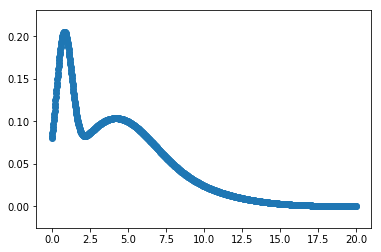

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x_data,y_data)

The function below computes the log likelihood of a data set given a mixture model i.e. the log of the probability of seeing the data if it was randomly selected from a population that adhered to the probability density function defined by the mixture model

In [25]:
def LLE(data,priors,myComponents):
    probs = myMixture(data,priors,myComponents)
    lle = sum(np.log(probs))
    return lle

We now look at two small data sets consisting of 6 instances. Which of these data sets are more likely to be generated using the mixture model defined above?

In [26]:
data = [0.5,0.8,1,5,6,9]
print(myMixture(data,priors,mycomps))
LLE(data,priors,mycomps)

[ 0.17533438  0.20479867  0.19636045  0.09967796  0.08578224  0.03456101]


-13.081374534584677

In [27]:
data = [1,3,1,3,7,7]
print(myMixture(data,priors,mycomps))
LLE(data,priors,mycomps)

[ 0.19636045  0.09417523  0.19636045  0.09417523  0.06707336  0.06707336]


-13.384739460696498

We now generate two data sets consisting of 100,000 instances each. The first follows a uniform distribution in the range [0,20]. The second is generated from the mixture model. Not surprisingly, the second data set has a higher average log likelihood

In [28]:
data = np.random.rand(10000)*20
data

array([  3.16111468,  18.11493089,  16.35129937, ...,  18.56677761,
         0.95591804,  14.90155631])

(array([ 1028.,   977.,   980.,  1023.,  1010.,   991.,  1004.,   986.,
         1018.,   983.]),
 array([  3.74236977e-03,   2.00321846e+00,   4.00269455e+00,
          6.00217064e+00,   8.00164673e+00,   1.00011228e+01,
          1.20005989e+01,   1.40000750e+01,   1.59995511e+01,
          1.79990272e+01,   1.99985033e+01]),
 <a list of 10 Patch objects>)

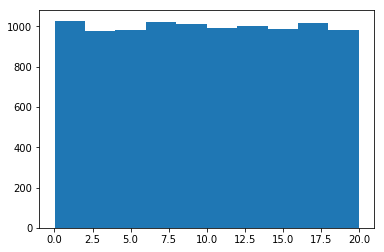

In [29]:
plt.hist(data)

In [30]:
LLE(data,priors,mycomps)/data.shape

array([-4.28060941])

The function below generates a sample data set of size sample_size that is generated from the mixture model defined above

In [31]:
def genSample(sample_size,priors,myComponents):
    myData = np.empty( shape=(0) )
    for comp,prior in zip(myComponents,priors):
        new_data = comp.rvs(int(sample_size*prior))
        myData = np.append(myData,new_data)
    return myData

In [32]:
#data is the time in min
data=[]
data1 = genSample(50,priors,mycomps) 
data2 = genSample(50,priors,mycomps) 
data3 = genSample(50,priors,mycomps) 
data4 = genSample(50,priors,mycomps) 
data5 = genSample(50,priors,mycomps) 
data=np.concatenate((data1,data2,data3,data4,data5))
print(type(data))
LLE(data,priors,mycomps)/data.shape

<class 'numpy.ndarray'>


array([-2.53301605])

In [33]:
data[data<0]=0

(array([ 75.,  34.,  38.,  38.,  29.,  11.,  12.,   7.,   3.,   3.]),
 array([  0.        ,   1.49968959,   2.99937918,   4.49906876,
          5.99875835,   7.49844794,   8.99813753,  10.49782712,
         11.9975167 ,  13.49720629,  14.99689588]),
 <a list of 10 Patch objects>)

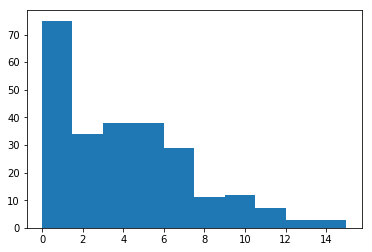

In [34]:
plt.hist(data)

# Data generation for user profile

In [35]:
click=[]
click1=np.random.binomial(1,0.7,50)
click2=np.random.binomial(1,0.7,50)
click3=np.random.binomial(1,0.7,50)
click4=np.random.binomial(1,0.7,50)
click5=np.random.binomial(1,0.7,50)
click=np.concatenate((click1,click2,click3,click4,click5))

In [36]:
def ClusterIndicesNumpy(clustNum, labels_array):
    return np.where(labels_array == clustNum)[0]

cluster0=ClusterIndicesNumpy(0, kmeans.labels_)
cluster1=ClusterIndicesNumpy(1, kmeans.labels_)
cluster2=ClusterIndicesNumpy(2, kmeans.labels_)
cluster3=ClusterIndicesNumpy(3, kmeans.labels_)
cluster4=ClusterIndicesNumpy(4, kmeans.labels_)
cluster5=ClusterIndicesNumpy(5, kmeans.labels_)
cluster6=ClusterIndicesNumpy(6, kmeans.labels_)
cluster7=ClusterIndicesNumpy(7, kmeans.labels_)
cluster8=ClusterIndicesNumpy(8, kmeans.labels_)
cluster9=ClusterIndicesNumpy(9, kmeans.labels_)

In [37]:
def random_doc(no_of_users):
    doc=[]
    doc=np.array(doc)
    for i in range(no_of_users):
        docid=[]
        docid=np.array(docid)
        n1=np.random.choice(cluster0,5)
        n2=np.random.choice(cluster1,5)
        n3=np.random.choice(cluster2,5)
        n4=np.random.choice(cluster3,5)
        n5=np.random.choice(cluster4,5)
        n6=np.random.choice(cluster5,5)
        n7=np.random.choice(cluster6,5)
        n8=np.random.choice(cluster7,5)
        n9=np.random.choice(cluster8,5)
        n10=np.random.choice(cluster9,5)
        docid=np.concatenate((n1,n2,n3,n4,n5,n6,n7,n8,n9,n10))
        doc=np.concatenate((doc,docid))
        
    return doc

In [38]:
#random_doc(5)

In [39]:
usr_id1=np.empty(50)
usr_id1.fill(1)
usr_id2=np.empty(50)
usr_id2.fill(2)
usr_id3=np.empty(50)
usr_id3.fill(3)
usr_id4=np.empty(50)
usr_id4.fill(4)
usr_id5=np.empty(50)
usr_id5.fill(5)
usr_id1 = np.concatenate((usr_id1,usr_id2,usr_id3,usr_id4,usr_id5))

art_rank=[]
for i in range(5):
    for j in range(50):
        art_rank.append(j+1)
art_rank=np.array(art_rank)

In [40]:
user_dict={"UserId":usr_id1,"ArticleId served":random_doc(5),"Article Rank":art_rank,"Click":click,"Time Spent(min)":data}
#user_dict={"art_id":random_doc(3)}

In [41]:
#user_dict

In [42]:
user_data=pd.DataFrame(data=user_dict)

In [43]:
user_data['Time Spent(min)']=user_data['Time Spent(min)']*user_data['Click']

In [44]:
type(user_data['Time Spent(min)'])

pandas.core.series.Series

In [72]:
user_data

,Article Rank,ArticleId served,Click,Time Spent(min),UserId,weight
0,1,2016.0,1,1.298325,1.0,1.000000
1,2,3263.0,1,0.174003,1.0,1.000000
2,3,2977.0,1,1.249176,1.0,1.000000
3,4,738.0,1,0.886259,1.0,2.000000
4,5,747.0,1,0.859930,1.0,1.000000
5,6,2412.0,0,0.000000,1.0,0.000000
6,7,1262.0,1,1.495432,1.0,1.000000
7,8,3929.0,1,1.351373,1.0,1.000000
8,9,3360.0,1,1.064472,1.0,1.000000
9,10,3015.0,1,0.000000,1.0,0.000000


# User profile

In [46]:
weight=[]
for i in range(250):
    artid=user_data['ArticleId served'][i]
    #print(artid)
    docs=(user_data[user_data['ArticleId served']==artid])
    #print(docs)
    time=docs['Time Spent(min)']
    avg_time=np.average(time) 
    weight.append(time.loc[i]/avg_time)

C:\Users\Hello\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [47]:
weight = np.array(weight)
weights_df = pd.DataFrame(data=weight,columns=['weight'])
weights_df= weights_df.fillna(0)
weights_df

,weight
0,1.000000
1,1.000000
2,1.000000
3,2.000000
4,1.000000
5,0.000000
6,1.000000
7,1.000000
8,1.000000
9,0.000000


In [48]:
user_data=pd.concat([user_data,weights_df],axis=1)
user_data

,Article Rank,ArticleId served,Click,Time Spent(min),UserId,weight
0,1,2016.0,1,1.298325,1.0,1.000000
1,2,3263.0,1,0.174003,1.0,1.000000
2,3,2977.0,1,1.249176,1.0,1.000000
3,4,738.0,1,0.886259,1.0,2.000000
4,5,747.0,1,0.859930,1.0,1.000000
5,6,2412.0,0,0.000000,1.0,0.000000
6,7,1262.0,1,1.495432,1.0,1.000000
7,8,3929.0,1,1.351373,1.0,1.000000
8,9,3360.0,1,1.064472,1.0,1.000000
9,10,3015.0,1,0.000000,1.0,0.000000


In [83]:
#Now we will take product of weight and doc-topic vector which will give us the topics on which the user has spent large amount of time
interest=[]
for i in range(250):
    art_id=user_data['ArticleId served'][i]
    #print(art_id)
    art_id=int(art_id)
    interest1=DocTopic[art_id]*user_data['weight'][i]
    interest.append(interest1)
#print(interest)

In [120]:
# now we take average of user's interest vectors which will give us the interest of the user in various topics
#For User1
a=interest[0]
b=interest[1]
for i in range(49):
    a=a+b
    b=interest[i+2]
usr1_interest=a/50

In [92]:
from functools import reduce

In [97]:
#For User2
user2=interest[50:100]
usr2_interest=reduce(lambda x,y:x+y,user2)/len(user2)

#For User3
user3=interest[100:150]
usr3_interest=reduce(lambda x,y:x+y,user3)/len(user3)

#For User4
user4=interest[150:200]
usr4_interest=reduce(lambda x,y:x+y,user4)/len(user4)

#For User5
user5=interest[200:250]
usr5_interest=reduce(lambda x,y:x+y,user5)/len(user5)

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

In [166]:
#For recommending 2 articles related to trending topics

avg_usr_interest=(usr1_interest+usr2_interest+usr3_interest+usr4_interest+usr5_interest)/5
#avg_usr_interest.reshape(1,50)
#print(avg_usr_interest)
#print(DocTopic.shape)
trend_cos_sim=cosine_similarity(DocTopic,avg_usr_interest.reshape(1,50))
trending=trend_cos_sim.ravel().argsort()[-2:]
trending

array([ 444, 2480], dtype=int64)

In [167]:
#For recommending 5 articles based on content filtering
#For User1
content_cos_sim1=cosine_similarity(DocTopic,usr1_interest.reshape(1,50))
content1=content_cos_sim1.ravel().argsort()[-5:]
print(content1)

#For User2
content_cos_sim2=cosine_similarity(DocTopic,usr2_interest.reshape(1,50))
content2=content_cos_sim2.ravel().argsort()[-5:]
print(content2)

#For User3
content_cos_sim3=cosine_similarity(DocTopic,usr3_interest.reshape(1,50))
content3=content_cos_sim3.ravel().argsort()[-5:]
print(content3)

#For User4
content_cos_sim4=cosine_similarity(DocTopic,usr4_interest.reshape(1,50))
content4=content_cos_sim4.ravel().argsort()[-5:]
print(content4)

#For User5
content_cos_sim5=cosine_similarity(DocTopic,usr5_interest.reshape(1,50))
content5=content_cos_sim5.ravel().argsort()[-5:]
print(content5)

[4343 1168  406  516  629]
[3169 3138 2365  444 3141]
[2689  444 3760 3304 2480]
[3304 3141 3760  444 2480]
[3024 2419 2480  559  444]


In [218]:
#For recommending 3 articles based on collaborative filtering

collab_sim1=cosine_similarity(usr1_interest.reshape(1,50),usr2_interest.reshape(1,50))
collab_sim2=cosine_similarity(usr1_interest.reshape(1,50),usr3_interest.reshape(1,50))
collab_sim3=cosine_similarity(usr1_interest.reshape(1,50),usr4_interest.reshape(1,50))
collab_sim4=cosine_similarity(usr1_interest.reshape(1,50),usr5_interest.reshape(1,50))

collab_sim5=cosine_similarity(usr2_interest.reshape(1,50),usr3_interest.reshape(1,50))
collab_sim6=cosine_similarity(usr2_interest.reshape(1,50),usr4_interest.reshape(1,50))
collab_sim7=cosine_similarity(usr2_interest.reshape(1,50),usr5_interest.reshape(1,50))

collab_sim8=cosine_similarity(usr3_interest.reshape(1,50),usr4_interest.reshape(1,50))
collab_sim9=cosine_similarity(usr3_interest.reshape(1,50),usr5_interest.reshape(1,50))

collab_sim10=cosine_similarity(usr4_interest.reshape(1,50),usr5_interest.reshape(1,50))

In [219]:
#For user 1
sim_1 = {'1_2': collab_sim1, '1_3': collab_sim2, '1_4': collab_sim3, '1_5': collab_sim4}
print(max(sim_1, key=sim_1.get))

#For user 2
sim_2 = {'2_1': collab_sim1, '2_3': collab_sim5, '2_4': collab_sim6, '2_5': collab_sim7}
print(max(sim_2, key=sim_2.get))

#For user 3
sim_3 = {'3_1': collab_sim2, '3_2': collab_sim5, '3_4': collab_sim8, '3_5': collab_sim9}
print(max(sim_3, key=sim_3.get))

#For user 4
sim_4 = {'4_1': collab_sim3, '4_2': collab_sim6, '4_3': collab_sim8, '4_5': collab_sim10}
print(max(sim_4, key=sim_4.get))

#For user 5
sim_5 = {'5_1': collab_sim4, '5_2': collab_sim7, '5_3': collab_sim9, '5_4': collab_sim10}
print(max(sim_5, key=sim_5.get))

1_5
2_5
3_4
4_3
5_3


In [220]:
# user1 and 5 have most similiar interests
avg15=(usr1_interest+usr5_interest)/2
cos_sim15=cosine_similarity(DocTopic,avg15.reshape(1,50))
u1=cos_sim15.ravel().argsort()[-3:] #these docs are recommended to user1

In [221]:
# user2 and 5 have most similiar interests
avg25=(usr2_interest+usr5_interest)/2
cos_sim25=cosine_similarity(DocTopic,avg25.reshape(1,50))
u2=cos_sim25.ravel().argsort()[-3:] #these docs are recommended to user2

In [222]:
# user3 and 4 have most similiar interests
avg34=(usr3_interest+usr4_interest)/2
cos_sim34=cosine_similarity(DocTopic,avg34.reshape(1,50))
u3=cos_sim34.ravel().argsort()[-3:] #these docs are recommended to user3

In [223]:
# user4 and 3 have most similiar interests
avg43=(usr3_interest+usr4_interest)/2
cos_sim43=cosine_similarity(DocTopic,avg43.reshape(1,50))
u4=cos_sim43.ravel().argsort()[-3:] #these docs are recommended to user4

In [224]:
# user5 and 3 have most similiar interests
avg53=(usr3_interest+usr5_interest)/2
cos_sim53=cosine_similarity(DocTopic,avg53.reshape(1,50))
u5=cos_sim53.ravel().argsort()[-3:] #these docs are recommended to user5

In [227]:
#recommendation for user1
recomm1=np.concatenate((trending,content1,u1))
recomm1

array([ 444, 2480, 4343, 1168,  406,  516,  629, 3141, 2480,  444], dtype=int64)

In [228]:
#recommendation for user2
recomm2=np.concatenate((trending,content2,u2))
recomm2

array([ 444, 2480, 3169, 3138, 2365,  444, 3141, 2480, 3141,  444], dtype=int64)

In [229]:
#recommendation for user3
recomm3=np.concatenate((trending,content3,u3))
recomm3

array([ 444, 2480, 2689,  444, 3760, 3304, 2480, 3760,  444, 2480], dtype=int64)

In [230]:
#recommendation for user4
recomm4=np.concatenate((trending,content4,u4))
recomm4

array([ 444, 2480, 3304, 3141, 3760,  444, 2480, 3760,  444, 2480], dtype=int64)

In [231]:
#recommendation for user5
recomm5=np.concatenate((trending,content5,u5))
recomm5

array([ 444, 2480, 3024, 2419, 2480,  559,  444, 3304,  444, 2480], dtype=int64)